In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import load_model
import re
from sklearn.preprocessing import LabelEncoder
embed_dim = 128
lstm_out = 196 

Using TensorFlow backend.
C:\Users\alfar\Anaconda3\envs\cs5590\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\alfar\Anaconda3\envs\cs5590\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\alfar\Anaconda3\envs\cs5590\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\alfar\Anaconda3\envs\cs5590\lib\sit

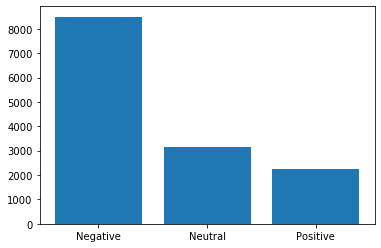

{'Negative': 8493, 'Neutral': 3142, 'Positive': 2236}

In [2]:
data = pd.read_csv('Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

import numpy as np
import matplotlib.pyplot as plt

counts = data['sentiment'].value_counts().to_dict()

height = [counts['Negative'], counts['Neutral'],counts['Positive']]
bars = ('Negative', 'Neutral', 'Positive')
y_pos = np.arange(len(bars))
 
plt.bar(y_pos, height)
 
plt.xticks(y_pos, bars)
 
plt.show()
counts


In [3]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))

In [4]:
for idx, row in data.iterrows():
    row[0] = row[0].replace('rt', ' ')

In [5]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)

X = pad_sequences(X)

In [6]:
def createmodel():
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

In [7]:
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['sentiment'])
y = to_categorical(integer_encoded)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [8]:
batch_size = 32
# model = createmodel()
model = load_model('TwitterModel.h5')
# model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size)
score,acc = model.evaluate(X_test,Y_test,verbose=1,batch_size=batch_size)
print(score)
print(acc)
print(model.metrics_names)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
4578/4578 [==============================] - 1s 304us/step
0.914157294039645
0.659676730632782
['loss', 'accuracy']


In [9]:
# model.save('TwitterModel.h5')

In [10]:
model = load_model('TwitterModel.h5')

In [11]:
toPredict = {0: "negative",1: "neutral",2: "positive"}
text = "A lot of good things are happening. We are respected again throughout the world, and that's a great thing.@realDonaldTrump"

print(text)
text = text.lower()
text = re.sub('[^a-zA-z0-9\s]', '', text)

x = tokenizer.texts_to_sequences([text])
x = pad_sequences(x, maxlen=28)

x = x[[0], :]
prediction = model.predict(x)[0]
for key, value in toPredict.items():
    print(value, ": %.2f "% (prediction[key]))


A lot of good things are happening. We are respected again throughout the world, and that's a great thing.@realDonaldTrump
negative : 0.31 
neutral : 0.03 
positive : 0.67 


In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
model = load_model('TwitterModel.h5')
model = KerasClassifier(build_fn=createmodel,verbose=1)
batch_size = [10, 20, 40]
epochs = [1, 2, 3]
param_grid = dict(batch_size=batch_size, epochs=epochs)
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



Epoch 1/1
1859/1859 [==============================] - 1s 626us/step
Epoch 1/1
1859/1859 [==============================] - 1s 682us/step
Epoch 1/1
1859/1859 [==============================] - 1s 750us/step
Epoch 1/1
1858/1858 [==============================] - 1s 785us/step
Epoch 1/1
1858/1858 [==============================] - 2s 895us/step
Epoch 1/2
7434/7434 [==============================] - 20s 3ms/step - loss: 0.8326 - accuracy: 0.6443
Epoch 2/2
1859/1859 [==============================] - 2s 909us/step
Epoch 1/2
7434/7434 [==============================] - 20s 3ms/step - loss: 0.8235 - accuracy: 0.6494
Epoch 2/2
1859/1859 [==============================] - 2s 962us/step
Epoch 1/2
7434/7434 [==============================] - 22s 3ms/step - loss: 0.8316 - accuracy: 0.6406
Epoch 2/2
1859/1859 [==============================] - 2s 1ms/step
Epoch 1/2
7435/7435 [==============================] - 22s 3ms/step - loss: 0.8291 - accuracy: 0.6445
Epoch 2/2
1858/1858 [=====================

1859/1859 [==============================] - 2s 1ms/step
Epoch 1/1
1858/1858 [==============================] - 2s 1ms/step
Epoch 1/1
1858/1858 [==============================] - 3s 1ms/step
Epoch 1/2
7434/7434 [==============================] - 24s 3ms/step - loss: 0.8493 - accuracy: 0.6329
Epoch 2/2
1859/1859 [==============================] - 3s 1ms/step
Epoch 1/2
7434/7434 [==============================] - 25s 3ms/step - loss: 0.8451 - accuracy: 0.6356
Epoch 2/2
1859/1859 [==============================] - 3s 2ms/step
Epoch 1/2
7434/7434 [==============================] - 27s 4ms/step - loss: 0.8559 - accuracy: 0.6312
Epoch 2/2
1859/1859 [==============================] - 3s 2ms/step
Epoch 1/2
7435/7435 [==============================] - 26s 4ms/step - loss: 0.8529 - accuracy: 0.6327
Epoch 2/2
1858/1858 [==============================] - 3s 2ms/step
Epoch 1/2
7435/7435 [==============================] - 27s 4ms/step - loss: 0.8408 - accuracy: 0.6342
Epoch 2/2
1858/1858 [==========

In [15]:
data = pd.read_csv('spam.csv', encoding='latin-1')

# Keeping only the neccessary columns
data = data[['v1','v2']]

data['text'] = data['v2']
data['classification'] = data['v1']
data = data[['text','classification']]



In [16]:

data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

In [17]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)


In [18]:

embed_dim = 128
lstm_out = 196
def createmodel():
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    

    return model


In [19]:

labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['classification'])
y = to_categorical(integer_encoded)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)



In [21]:
batch_size = 32
model = createmodel()

model = load_model('Spam.h5')

print(model.summary())


# history = model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 1)
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)

print(score)
print(acc)
print(model.metrics_names)

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 152, 128)          256000    
_________________________________________________________________
lstm_49 (LSTM)               (None, 196)               254800    
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/7
3733/3733 [==============================] - 77s 21ms/step - loss: 0.1748 - accuracy: 0.9362
Epoch 2/7
3733/3733 [==============================] - 74s 20ms/step - loss: 0.0414 - accuracy: 0.9874
Epoch 3/7
3733/3733 [==============================] - 74s 20ms/step - loss: 0.0201 - accuracy: 0.9938
Epoch 4/7
3733/3733 [==============================] - 77s 21ms

In [22]:

model.save("Spam.h5")

In [26]:
txt = "Call now! and get free stuff!"

print(txt)
txt = txt.lower()
txt = re.sub('[^a-zA-z0-9\s]', '', txt)

x = tokenizer.texts_to_sequences([txt])
x = pad_sequences(x, maxlen=152)

x = x[[0], :]

prediction = model.predict(x)[0]
toWord = {
    0: "ham",
    1: "spam"
}
for key, value in toWord.items():
    print(value, ": ", prediction[key])



Call now! and get free stuff!
ham :  0.07988643
spam :  0.92011356
